In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, root_mean_squared_log_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

### Feature Tuning and Preprocessing

In [5]:
def process_num_feats(data):
    data['TotalSF'] = data['1stFlrSF'] + data['2ndFlrSF']
    not_useful_num = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', '1stFlrSF', '2ndFlrSF',  'GarageYrBlt']
    data = data.drop(columns=not_useful_num)

    # imputing
    imputer = SimpleImputer(strategy="constant", fill_value=0)
    imputed_data = pd.DataFrame(imputer.fit_transform(data), index=data.index)
    imputed_data.columns = data.columns
    return imputed_data

def process_categ_feats(data):
    not_useful_categ = ['Alley', 'Condition1', 'Condition2', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'SaleType', 'SaleCondition']
    categ_with_null = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MiscFeature']
    data = data.drop(columns = categ_with_null + not_useful_categ)

    # label encoding
    for col in data.columns:
        data[col], _ = data[col].factorize()
    return data

def process_data(data):
    categorical_feats = data.select_dtypes(include=['object'])
    numerical_feats = data.select_dtypes(exclude=['object'])

    proc_categ_feats = process_categ_feats(categorical_feats)
    proc_num_feats = process_num_feats(numerical_feats)

    proc_data = pd.concat([proc_num_feats, proc_categ_feats], axis=1)
    return proc_data

In [6]:
train_data = pd.read_csv('train.csv', index_col='Id')
test_data = pd.read_csv('test.csv', index_col='Id')

processed_train_data = process_data(train_data)
processed_test_data = process_data(test_data)

In [7]:
# processed_train_data.head()
processed_test_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,BsmtFullBath,...,Exterior2nd,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,KitchenQual,Functional,PavedDrive
Id,,,,,,,,,,,,,,,,,,,,,
1461,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,882.0,896.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1462,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,1329.0,1329.0,0.0,...,1,0,0,0,0,0,0,1,0,0
1463,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,928.0,1629.0,0.0,...,0,0,0,1,0,1,0,0,0,0
1464,60.0,78.0,9978.0,6.0,6.0,1998.0,1998.0,926.0,1604.0,0.0,...,0,0,0,1,0,2,0,1,0,0
1465,120.0,43.0,5005.0,8.0,5.0,1992.0,1992.0,1280.0,1280.0,0.0,...,2,1,0,1,0,2,0,1,0,0


In [8]:
x = processed_train_data.copy()
y = x.pop('SalePrice')

x.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,BsmtFullBath,...,Exterior2nd,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,KitchenQual,Functional,PavedDrive
Id,,,,,,,,,,,,,,,,,,,,,
1,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,856.0,1710.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,1262.0,1262.0,0.0,...,1,1,0,1,0,0,0,1,0,0
3,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,920.0,1786.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,756.0,1717.0,1.0,...,2,1,0,2,0,1,0,0,0,0
5,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,1145.0,2198.0,1.0,...,0,0,0,0,0,0,0,0,0,0


#### Relevant features using MI score

In [9]:
discrete_features = x.dtypes == int
mi_scores = mutual_info_regression(x, y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=x.columns)
mi_scores = mi_scores.sort_values(ascending=False)

len(mi_scores)

52

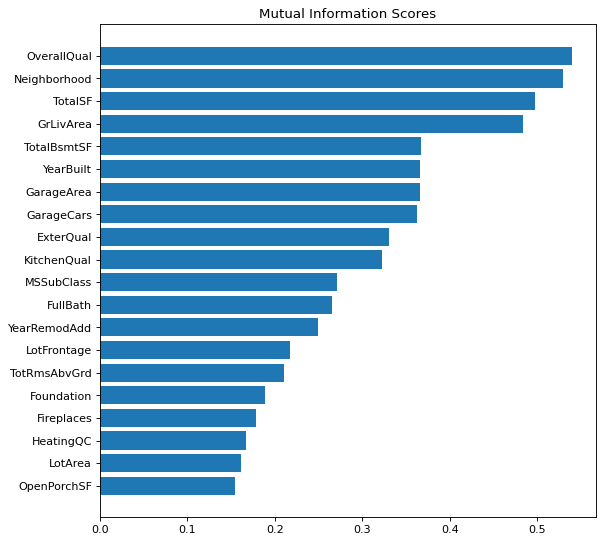

In [10]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=80, figsize=(8, 8))
plot_mi_scores(mi_scores[:20])

In [11]:
interesting_features = list(mi_scores.index[:])
x = x[interesting_features]
x

,OverallQual,Neighborhood,TotalSF,GrLivArea,TotalBsmtSF,YearBuilt,GarageArea,GarageCars,ExterQual,KitchenQual,...,BsmtHalfBath,Functional,3SsnPorch,LandSlope,Street,Utilities,PoolArea,MiscVal,YrSold,MoSold
Id,,,,,,,,,,,,,,,,,,,,,
1,7.0,0,1710.0,1710.0,856.0,2003.0,548.0,2.0,0,0,...,0.0,0,0.0,0,0,0,0.0,0.0,2008.0,2.0
2,6.0,1,1262.0,1262.0,1262.0,1976.0,460.0,2.0,1,1,...,1.0,0,0.0,0,0,0,0.0,0.0,2007.0,5.0
3,7.0,0,1786.0,1786.0,920.0,2001.0,608.0,2.0,0,0,...,0.0,0,0.0,0,0,0,0.0,0.0,2008.0,9.0
4,7.0,2,1717.0,1717.0,756.0,1915.0,642.0,3.0,1,0,...,0.0,0,0.0,0,0,0,0.0,0.0,2006.0,2.0
5,8.0,3,2198.0,2198.0,1145.0,2000.0,836.0,3.0,0,0,...,0.0,0,0.0,0,0,0,0.0,0.0,2008.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,6.0,17,1647.0,1647.0,953.0,1999.0,460.0,2.0,1,1,...,0.0,0,0.0,0,0,0,0.0,0.0,2007.0,8.0
1457,6.0,6,2073.0,2073.0,1542.0,1978.0,500.0,2.0,1,1,...,0.0,1,0.0,0,0,0,0.0,0.0,2010.0,2.0
1458,7.0,2,2340.0,2340.0,1152.0,1941.0,252.0,1.0,2,0,...,0.0,0,0.0,0,0,0,0.0,2500.0,2010.0,5.0


In [12]:
def get_score(x, y, model):
    scores = -1 * cross_val_score(model, x, y, cv = 5, scoring="neg_root_mean_squared_log_error", n_jobs=-1)
    return scores.mean()

In [96]:
# rfmodel = RandomForestRegressor(random_state=1)
# rfmodel.fit(trainx, trainy)

# predy = rfmodel.predict(valx)
# error = root_mean_squared_log_error(valy, predy)
# print(error)

### Hyperparameter tuning on
* n_estimators
* max_depth
* min_samples_split

#### Finding range of interest for each hyperparameter

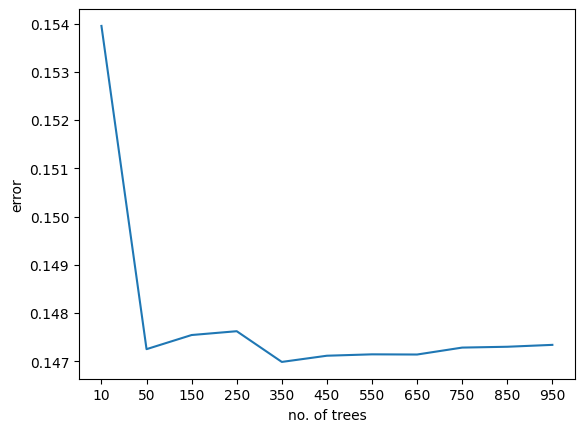

In [13]:
# figuring out effective range for n_estimators
try_values = [10] + [50*i for i in range(1, 21, 2)]
scores = []

for n_est in try_values: 
    model = RandomForestRegressor(n_estimators=n_est, random_state=2)
    score = get_score(x, y, model)
    scores.append(score)
    
    
plt.xlabel('no. of trees')
plt.xticks(ticks=range(len(try_values)), labels=try_values)
plt.ylabel('error')

plt.plot(scores)

Conclusion: For N-Estimators, 30-450 should be the range we tune it between since beyond that there is no significant effect on the model

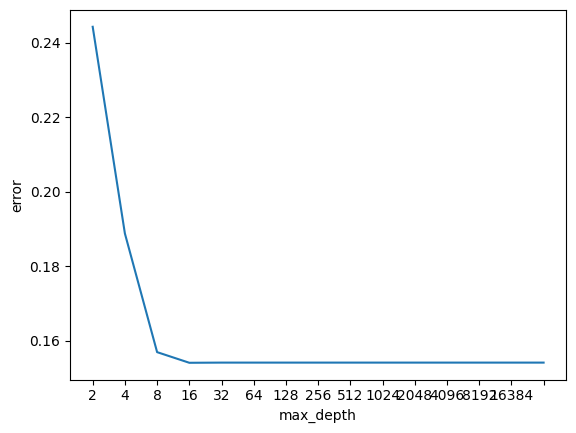

In [337]:
# figuring out effective range for max_depth
try_values = [2**i for i in range(1, 15)] + [None]
scores = []

for max_depth in try_values: 
    model = RandomForestRegressor(max_depth=max_depth, random_state=2)    
    score = get_score(x, y, model)
    scores.append(score)

    
plt.xlabel('max_depth')
plt.xticks(ticks=range(len(try_values)), labels=try_values)
plt.ylabel('error')

plt.plot(scores)

Conclusion: Range of interest for max depth is 4-18

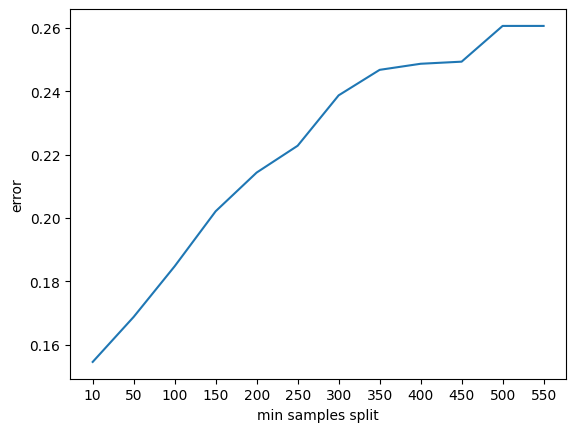

In [338]:
# figuring out effective range for min_samples_split
try_values = [10] + [50*i for i in range(1,12)]
scores = []

for mins in try_values: 
    model = RandomForestRegressor(min_samples_split=mins, random_state=2)
    score = get_score(x, y, model)
    scores.append(score)    

    
plt.xlabel('min samples split')
plt.xticks(ticks=range(len(try_values)), labels=try_values)
plt.ylabel('error')

plt.plot(scores)

Conlusion: min_samples_split should be kept somewhere between 10-100

#### Finding the best combo of hyper params from the range of interests

In [14]:
rfmodel = RandomForestRegressor(random_state = 2)
params = {'n_estimators': [i for i in range(10, 500, 30)], 
          'max_depth': [i for i in range(4, 18, 2)],
          'min_samples_split': [i for i in range(10, 100, 5)]}
tuned_model = GridSearchCV(rfmodel, param_grid = params, scoring = "neg_root_mean_squared_error", n_jobs = -1)

In [15]:
tuned_model.fit(x, y)
print(tuned_model.best_params_)
print(tuned_model.best_score_)

{'max_depth': 14, 'min_samples_split': 10, 'n_estimators': 340}
-31192.38751402474


### Making Predictions

In [16]:
testx = processed_test_data[interesting_features]
testx

,OverallQual,Neighborhood,TotalSF,GrLivArea,TotalBsmtSF,YearBuilt,GarageArea,GarageCars,ExterQual,KitchenQual,...,BsmtHalfBath,Functional,3SsnPorch,LandSlope,Street,Utilities,PoolArea,MiscVal,YrSold,MoSold
Id,,,,,,,,,,,,,,,,,,,,,
1461,5.0,0,896.0,896.0,882.0,1961.0,730.0,1.0,0,0,...,0.0,0,0.0,0,0,0,0.0,0.0,2010.0,6.0
1462,6.0,0,1329.0,1329.0,1329.0,1958.0,312.0,1.0,0,1,...,0.0,0,0.0,0,0,0,0.0,12500.0,2010.0,6.0
1463,5.0,1,1629.0,1629.0,928.0,1997.0,482.0,2.0,0,0,...,0.0,0,0.0,0,0,0,0.0,0.0,2010.0,3.0
1464,6.0,1,1604.0,1604.0,926.0,1998.0,470.0,2.0,0,1,...,0.0,0,0.0,0,0,0,0.0,0.0,2010.0,6.0
1465,8.0,2,1280.0,1280.0,1280.0,1992.0,506.0,2.0,1,1,...,0.0,0,0.0,0,0,0,0.0,0.0,2010.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,4.0,23,1092.0,1092.0,546.0,1970.0,0.0,0.0,0,0,...,0.0,0,0.0,0,0,0,0.0,0.0,2006.0,6.0
2916,4.0,23,1092.0,1092.0,546.0,1970.0,286.0,1.0,0,0,...,0.0,0,0.0,0,0,0,0.0,0.0,2006.0,4.0
2917,5.0,21,1224.0,1224.0,1224.0,1960.0,576.0,2.0,0,0,...,0.0,0,0.0,0,0,0,0.0,0.0,2006.0,9.0


In [17]:
test_preds = tuned_model.predict(testx)

In [18]:
output = pd.DataFrame({'Id': test_data.index,
                       'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)

In [19]:
print('Done!')

Done!
